# Usage Examples

Simple examples of how to use the `grsq` module, based on the unit tests included in the package. Go over them to familiarize yourself with how to use the module, and make sure to read (and cite) the paper accompanying this package[[1]](#1).

The module contains two main classes, `RDF` and the `RDFSet`, as well as a class containing truncation damping windows, `Damping`. 

## The `RDF` Class:
an `RDF` object needs to contain all attributes of an RDF sampled from MD simulations, provides methods to correct it for finite-size effects, and to calculate its corresponding structure factor, S(q).  

###### The main attributes are:  
- `rdf.r`: The r vector defining the bins in which the RDF was sampled  
- `rdf.g`: The g(r) values at each r bin  
- `rdf.name1`: Name of the first atom types (sampled 'from')  
- `rdf.name2`: Name of the second atom types  (sampled 'to')  
- `rdf.region1`: Does atom type 1 belong to the `'solute'` or `'solvent'`?  
- `rdf.region2`: Does atom type 2 belong to the `'solute'` or `'solvent'`?  
- `rdf.n1`: Number of atoms with atom type 1  
- `rdf.n2`: Number of atoms with atom type 2  
- `rdf.volume`: Volume in Å$^3$ of the MD box in which the RDF was sampled  
- `rdf.qvec`: Scattering vector

- `rdf.rho_norm`: The global density your RDF sampling program used to normalize the RDF:
   `'N'` (Like MDAnalysis), or `'KD'` (Like VMD). 'KD' stands for 'Kronecker Delta', as VMD normalizes with (N - $\delta_{ij}$) / V  


    
 
There are some further functionalities that can be used by also setting one or more of the following attributes:

- `rdf.damp`: (optional) an instance of the Damping class (see below)  
- `rdf.r_max`: at what $r$ to stop the integration. Default is `None`, meaning that the integration will continue until the end of the supplied r vector. Truncating the integration before can be useful for generating S(0; R) plots.
- `rdf.r_avg`: Will use the average value g(r > r_avg) instead of 1 in the S(q) integral. This very simple finite size correction has no physical justification, and should be used with caution (or not at all). 

###### Main methods: 
- `rdf.structure_factor()`: Calculate the structure factor S(q) from the RDF  
- `rdf.i_term1()`: Calculate the first, atomic x-ray scattering term from the RDF  
- `rdf.i_term2()`: Calculate the second term

###### Finite size corrections:
Furthermore, the following corrections are available:
- `rdf.volume_correct(Rl)`: Apply the volume correction to the RDF, using a spherical $V_l$ volume of radius `Rl`:
$$
g_{lm}^\mathrm{\infty}(r) = \frac{\rho_m}{\rho_\mathrm{eff}} g_{lm}^N(r) =  g_{lm}^N(r)\rho_m \frac{V_\mathrm{cell} - V_l}{N_m - \delta_{lm}},
$$
- `rdf.perera_correct(Rl, r_avg)`: Apply the correction from Perera et al[[2]](#2) 
$$
    g^\mathrm{\infty}_{lm}(r) = g^N_{lm}(r) \left [ 
                    1 + \frac{1 - g^{N,0}}{2}  \left( 1 + \tanh \left( \frac{r - \kappa_{lm}}{\alpha_{lm}} \right)   \right)
                  \right ].
$$
Where $g^{N,0}$ is obtained by setting `r_avg` to get the average value of g(r > r_avg), and `Rl` = $\kappa_{lm} / 2$, to be consistent with the volume correction, as well as the recommendations from the original paper.

- `rdf.vdv_correct()`: Apply the Ganguly / van der Vegt correction[[3]](#3):
$$
g^\mathrm{\infty}_\mathrm{lm}(r) = g^N_\mathrm{lm}(r) \frac{N_m}{N_m - \left[  (\Delta N(r) + \delta_{lm}) \left( 1 - \frac{(4/3) \pi r^3}{V_\mathrm{cell}} \right)^{-1}  \right]}
$$
See refs [[1]](#1) & [[3]](#3) for an explanation of this correction. 


###### Support methods:
- `rdf.get_info()`: Get a quick overview of the data contained in the object  
- `rdf.fit(Rl_guess, fit_start=25, fit_stop=50)`: Fit the excluded volume radius.  
    Can be used together with `rdf.volume_correct(Rl)` to estimate `Rl`. It minimizes g(r) - 1 from `fit_start` to `fit_stop`

Try `?RDF` or `help(RDF)` for more info.


## The `RDFSet` Class:
A modified `OrderedDict` class that can contain a set of `RDF` objects to apply corrections and calculate the scattering signals from the entire set. Given an instance `rdfs = RDFSet()`, You can access single RDF objects in two ways:

1. By their key, which will be a tuple: `rdfs[(rdf.name1, rdf.region1, rdf.name2, rdf.region2)]`  
   e.g. for the O-O rdf in water: `rdfs[('O', 'solvent','O', 'solvent')]`... 
2. ... which is somewhat cumbersome, so you can also simple use an index: `rdfs[0]`


You can add an `rdf` object: `rdfs.add_rdf(rdf)`, which adds $g_{ij}(r)$. `rdfs.add_flipped(rdf)` adds $g_{ji}(r)$


You can also loop over it, to e.g. apply corrections:
```
for i, (key, rdf) in enumerate(rdfs.items()):
    rdf.g = rdf.volume_correct(Rls[i])  # correcting the rdf in-place
```

###### Other support methods:
- `rdfs.show()`: Returns information of the set

###### Corrections:
- `rdfs.vdv_correct()`: Apply the Ganguly / van der Vegt correction to all solute-solvent and solvent-solvent RDFs in set  
The other corrections need to have individual parameters specified for each term.


###### Scattering methods:
- `rdfs.get_iq(qvec=None, cross=False, damping=None)` Get the total coherent x-ray scattering signal from entire set.  You can specify `qvec` and `Damping` to overwrite whatever is already contained in each RDF object. 
- `rdfs.get_solute()`: Returns the scattering of only the solute-solute atom type RDFs  
- `rdfs.get_solvent()`: Returns the scattering of only the solvent-solvent atom type RDFs  
- `rdfs.get_cross()`: Returns the scattering of only the solute-solvent and solvent-solute atom type RDFs  
- `rdfs.get_dv()`: Returns the excluded volume-scattering

All methods take `qvec` and `damping` as arguments. 


### References
<a id="1">[1]</a> Dohn et al, in preparation, 2023  
<a id="2">[2]</a> https://doi.org/10.1039/c3fd00072a  
<a id="3">[3]</a> https://doi.org/10.1080/08927022.2017.1416114



In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os, sys, glob, matplotlib, rmsd
import numpy as np
%matplotlib widget

import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})  

from ase.io import read

sys.path.append('../src/')  # You can remove this if you have installed via pip

from grsq.grsq import RDF, RDFSet, rdfset_from_dir
from grsq.damping import Damping
from grsq.debye import Debye

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors


## 2 Particle Solute 
Identical atom types. RDFs generated using `vmd`: https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD 

With the volume set to 10x10x10 Å, and a 0.0001 Å bin size.


This test also uses the implementation of the discrete Debye function in `Debye`, see lines 1-3.

2
2


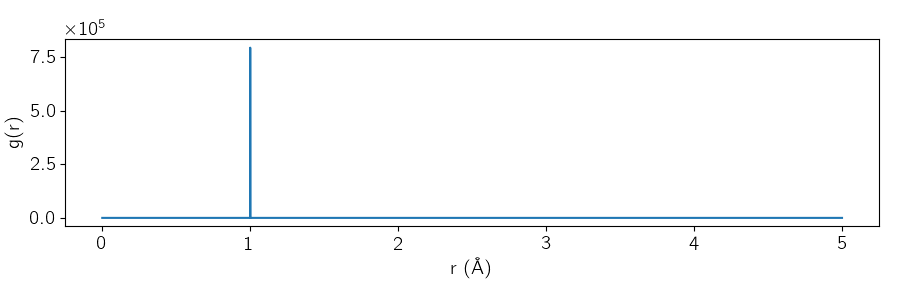

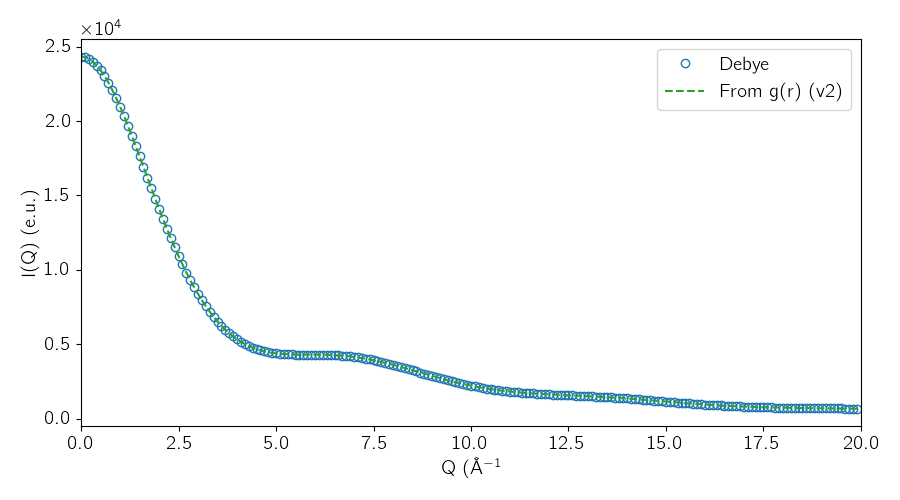

In [2]:
atoms = read('../tests/data/xray_2particle/test.xyz')
deb = Debye(qvec=np.arange(0, 20, 0.01))
i_deb = deb.debye(atoms)

stoich = {'Pt_u':2}
V = 10**3

rdf_dat = np.genfromtxt('../tests/data/xray_2particle/gPt_u-Pt_u.dat')

rdf = RDF(rdf_dat[:, 0], rdf_dat[:, 1], 'Pt', 'Pt', 'solute', 'solute', qvec=deb.qvec)
rdf.n1 = 2
rdf.n2 = 2
rdf.volume = V

iq = rdf.i_term1()
iq += rdf.i_term2()

fig, ax = plt.subplots(1, 1, figsize=(9, 3)) 
ax.plot(rdf_dat[:, 0 ], rdf_dat[:, 1])
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
fig.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(deb.qvec[::10], i_deb[::10], 'C0o', label='Debye', mfc='None')
ax.plot(rdf.qvec,  iq, 'C2--', label='From g(r) (v2)')

ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('I(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()



### 3 Particle system again, using the RDFSet() class
Pt, Pt, Ar. Artificial system, to check book-keeping. 

The RDF needs to be finely sampled for the discrete and density-based formulation to be numerically equal, hence the somewhat long calculation time.

In [3]:
rdfs = rdfset_from_dir('../tests/data/xray_3particle/', 
                       '../tests/data/xray_3particle/ptptar.xyz', volume=10**3)
rdfs.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | Ar-solute--Pt-solute    | N1:     1, N2:     2 | solute , solute  | 1000.0000 |
| 001 | Pt-solute--Ar-solute    | N1:     2, N2:     1 | solute , solute  | 1000.0000 |
| 002 | Pt-solute--Pt-solute    | N1:     2, N2:     2 | solute , solute  | 1000.0000 |


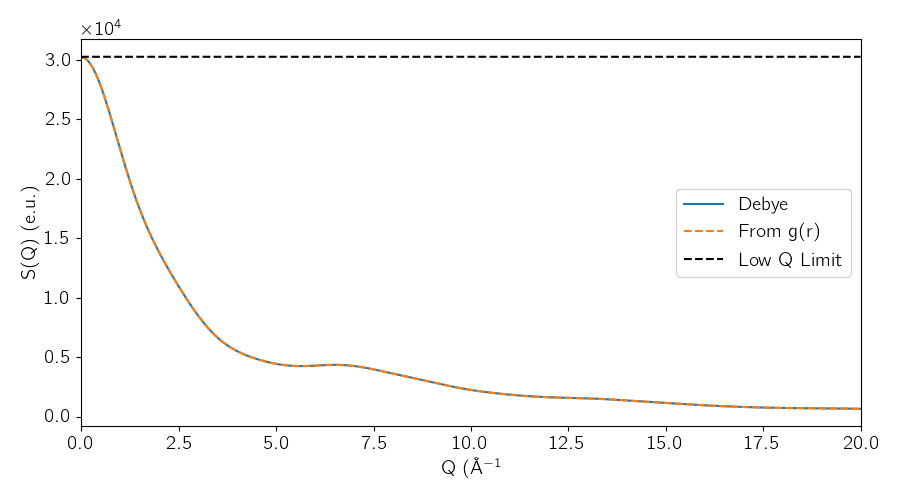

In [4]:
qvec = np.arange(0, 20, 0.01)

atoms = read('../tests/data/xray_3particle/ptptar.xyz')
deb = Debye(qvec=qvec)
i_deb = deb.debye(atoms)
num_electrons_squared = sum(atoms.get_atomic_numbers())**2

i_g = rdfs.get_iq(qvec)

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, i_deb, 'C0', label='Debye')
ax.plot(qvec, i_g, 'C1--', label='From g(r)')
ax.plot(qvec, np.ones_like(qvec) * num_electrons_squared, 'k--', label='Low Q Limit')
ax.set_xlim([0, 20])
ax.set_xlabel('Q (Å$^{-1}$')
ax.set_ylabel('S(Q) (e.u.)')
ax.legend(loc='best');
fig.tight_layout()

Also test that the coordination number method counts 2 Pt atoms from Ar

In [5]:
rdf = rdfs[0]
print(rdf.get_info())
rdf.coordination_number(0, 100)

Ar-solute--Pt-solute: RDF with 1 particles in solute and 2 in solute. Volume: 1000


2.000000151270344

### Water from VMD RDFs

These are normalized with (10.1016/j.jcp.2011.01.048) 

$$
\rho = \frac{N - \delta_{lm}}{V}
$$

Which results in the van der Vegt correction not requiring to add back the particle we start from, in the $\Delta N_{lm}(r)$ term

In [6]:
V = 122900.85207774633
stoich = {'H_v': 8190, 'O_v': 4095}
rdfs = rdfset_from_dir('../tests/data/xray_water/', 
                       volume=V, 
                       stoich=stoich)
rdfs.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | H-solvent--H-solvent    | N1:  8190, N2:  8190 | solvent, solvent | 122900.8521 |
| 001 | H-solvent--O-solvent    | N1:  8190, N2:  4095 | solvent, solvent | 122900.8521 |
| 002 | O-solvent--H-solvent    | N1:  4095, N2:  8190 | solvent, solvent | 122900.8521 |
| 003 | O-solvent--O-solvent    | N1:  4095, N2:  4095 | solvent, solvent | 122900.8521 |


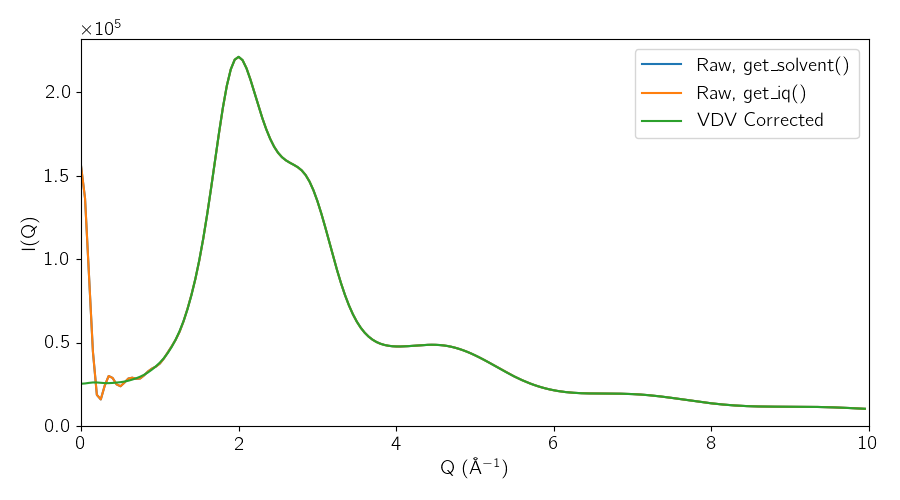

In [7]:
qvec = np.arange(0, 10, 0.05)

ig_s = rdfs.get_solvent(qvec)  # using solvent-only function
ig_a = rdfs.get_iq(qvec)       # using total scat 
rdfs.vdv_correct()
igc_s = rdfs.get_solvent()     # solvent-only, corrected

fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, ig_s, label='Raw, get_solvent()')
ax.plot(qvec, ig_a, label='Raw, get_iq()')
ax.plot(qvec, igc_s, label='VDV Corrected')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

You can also slice and add `RDFSet`s

In [8]:
test = rdfs[:2] + rdfs[2:]
test.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | H-solvent--H-solvent    | N1:  8190, N2:  8190 | solvent, solvent | 122900.8521 |
| 001 | H-solvent--O-solvent    | N1:  8190, N2:  4095 | solvent, solvent | 122900.8521 |
| 002 | O-solvent--H-solvent    | N1:  4095, N2:  8190 | solvent, solvent | 122900.8521 |
| 003 | O-solvent--O-solvent    | N1:  4095, N2:  4095 | solvent, solvent | 122900.8521 |


In [9]:
qvec = np.arange(0, 10, 0.05)
old = rdfs.get_iq(qvec)
new = rdfs.get_iq(qvec)

assert ((old - new ) == 0).all()

Corrected and damped

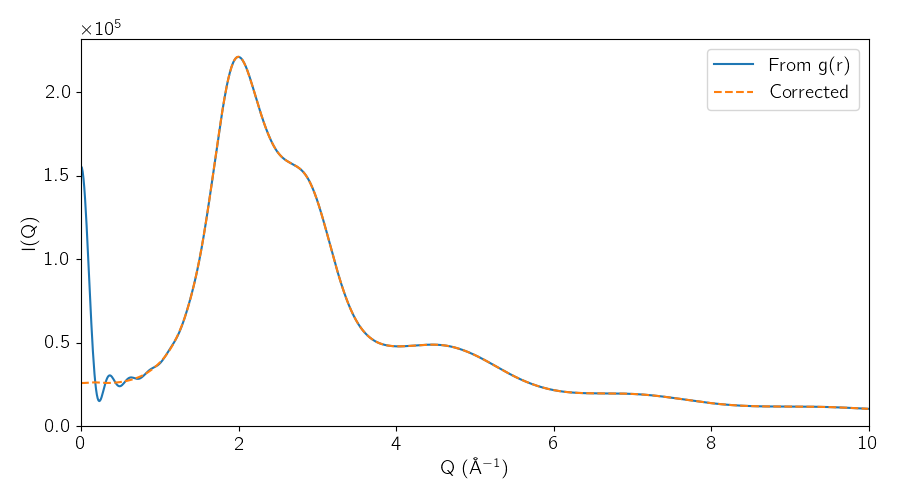

In [12]:
import copy
rdfs = rdfset_from_dir('../tests/data/xray_water/', 
                       volume=V, 
                       stoich=stoich)

qvec = np.arange(0, 10, 0.01)
r_max = rdfs[0].r[-1]

corrected_set = RDFSet()
for key, rdf in rdfs.items():
    rdf_vc = copy.deepcopy(rdf)
    rdf_vc.g = rdf_vc.vdv_correct()
    rdf_vc.r_max = r_max
    rdf_vc.damp = Damping('zederkof', r_max=r_max, r_cut=r_max-1)# None #Damping('lorch', L=r_max)
    corrected_set[key] = rdf_vc
    
iq_rdf_corr = corrected_set.get_iq(qvec=qvec)
qvec = np.arange(0, 10, 0.01)

sg_2 = rdfs.get_iq(qvec=qvec)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, sg_2, 'C0-', label='From g(r)')
ax.plot(qvec, iq_rdf_corr, 'C1--', label='Corrected')
ax.set_xlim([0, 10])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

### Water from MDAnalysis RDFs

In contrast, are normalized with (see the source code):

$$
\rho = \frac{N}{V}
$$

Which results in the van der Vegt correction as it is written up originally (see 10.1021/ct301017q).

In [57]:
rdfs = rdfset_from_dir('../tests/data/mda_water/', volume=V, stoich=stoich)
rdfs.show()

|  #  | KEY                     |     STOICHOMETRY     | REGION1, REGION2 | VOLUME 
| 000 | H-solvent--H-solvent    | N1:  8190, N2:  8190 | solvent, solvent | 122900.8521 |
| 001 | H-solvent--O-solvent    | N1:  8190, N2:  4095 | solvent, solvent | 122900.8521 |
| 002 | O-solvent--H-solvent    | N1:  4095, N2:  8190 | solvent, solvent | 122900.8521 |
| 003 | O-solvent--O-solvent    | N1:  4095, N2:  4095 | solvent, solvent | 122900.8521 |


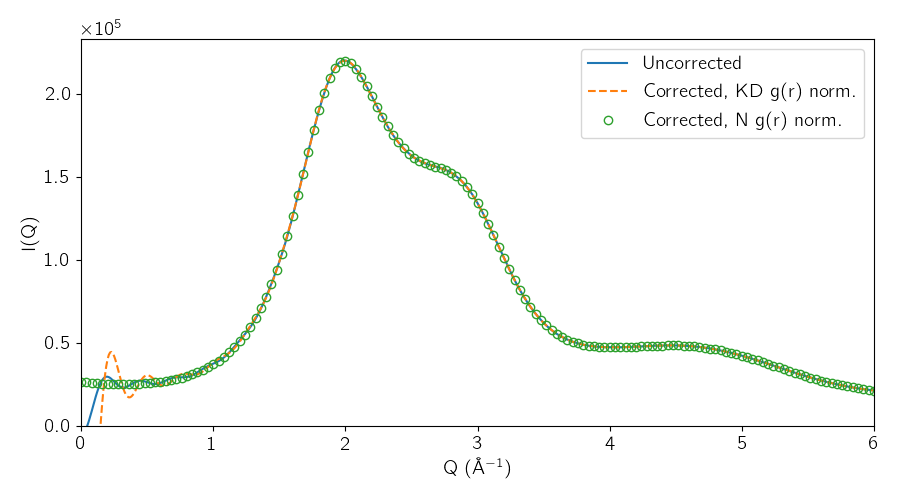

In [58]:
import copy

qvec = np.arange(0, 10, 0.01)
r_max = rdfs[0].r[-1]

sg_2 = rdfs.get_iq(qvec=qvec)
fig, ax = plt.subplots(1, 1, figsize=(9, 5)) 
ax.plot(qvec, sg_2, 'C0-', label='Uncorrected')

linestyles = ('--', 'o')
for i, rho_norm in enumerate(['KD', 'N']):
    corrected_set = RDFSet()
    for key, rdf in rdfs.items():
        rdf.rho_norm = rho_norm
        rdf_vc = copy.deepcopy(rdf)
        rdf_vc.g = rdf_vc.vdv_correct()
        rdf_vc.r_max = r_max
        rdf_vc.damp = Damping('zederkof', r_max=r_max, r_cut=r_max-1)# None #Damping('lorch', L=r_max)
        corrected_set[key] = rdf_vc

    iq_rdf_corr = corrected_set.get_iq(qvec=qvec)
    qvec = np.arange(0, 10, 0.01)
    ax.plot(qvec[::i*3 + 1], iq_rdf_corr[::i*3 + 1], f'C{1 + i}{linestyles[i]}', label=f'Corrected, {rho_norm} g(r) norm.', mfc='none')

ax.set_xlim([0, 6])
ax.set_ylim([0, 2.33e5])
ax.set_xlabel('Q (Å$^{-1})$')
ax.set_ylabel('I(Q)')
ax.legend(loc='best');
fig.tight_layout()

## All corrections, all dampings

1.4213563705045986 0.822914248493976
0.0 0.4734868077309238
0.0 0.4734868077309238
1.8599439939218725 1.8711965707831326


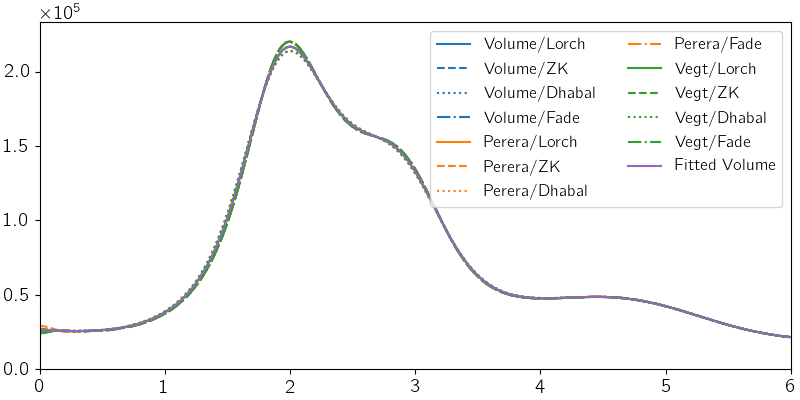

In [59]:
import copy 
V = 122900.85207774633
stoich = {'H_v': 8190, 'O_v': 4095}
rdfs_raw = rdfset_from_dir('../tests/data/mda_water/', volume=V, stoich=stoich)
r_max = rdfs_raw[0].r[-1]

lrh = Damping('lorch', L=r_max)
zkf = Damping('zederkof', r_max=r_max, r_cut=r_max-1)
dhb = Damping('dhabal', r_max=r_max)
fad = Damping('panman', L=10)
dampings = [lrh, zkf, dhb, fad]
corrections = ('volume', 'perera', 'vegt')

qvec = np.arange(0, 6, 0.01)

lines = ['-', '--', ':', '-.']
dnames = ['Lorch', 'ZK', 'Dhabal', 'Fade']

results = np.zeros((len(qvec), 12))

fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 4))
ct = 0
for c, corr in enumerate(corrections):
    for d, damp in enumerate(dampings):
        rdfs = copy.deepcopy(rdfs_raw)
        for rdf in rdfs.values():
            rdf.rho_norm = 'N'
            r_first_nonzero = rdf.r[np.where(rdf.g > 0)[0]][0]
            r_c = r_first_nonzero - 0.5
            corr_vars = ({'Ri':r_c}, {'Ri':r_first_nonzero, 'R_avg':10.6579}, {})
            rdf.g = rdf.correct(method=corr, **(corr_vars[c]))
            rdf.damp = damp

        iq = rdfs.get_solvent(qvec=qvec)
        ax.plot(qvec, iq, f'C{c}{lines[d]}', label=corrections[c].title() + f'/{dnames[d]}')
        results[:, ct] = iq
        ct += 1

# also use the fit of the volume
rdfs = copy.deepcopy(rdfs_raw)
for rdf in rdfs.values():
    rdf.rho_norm = 'N'
    r_first_nonzero = rdf.r[np.where(rdf.g > 0)[0]][0]
    r_c = r_first_nonzero - 0.5
    opt = rdf.fit(r_c, fit_start=15, fit_stop=r_max)
    print(opt.x[0], r_c)
    rdf.g = rdf.correct(method='volume', Ri=opt.x[0])
    rdf.damp = lrh
iq = rdfs.get_solvent(qvec=qvec)
ax.plot(qvec, iq, f'C4', label='Fitted Volume')    
ax.set_xlim([0, 6])
ax.set_ylim([0, 2.33e5])
ax.legend(loc='best', fontsize=12, ncol=2)
